In [1]:
#!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

import category_encoders as ce


In [3]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

In [4]:
train.info(), train.shape, test.shape, sample.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27100 non-null  int64 
 1   job        27100 non-null  object
 2   marital    27100 non-null  object
 3   education  27100 non-null  object
 4   default    27100 non-null  object
 5   balance    27100 non-null  int64 
 6   housing    27100 non-null  object
 7   loan       27100 non-null  object
 8   contact    27100 non-null  object
 9   day        27100 non-null  int64 
 10  month      27100 non-null  object
 11  duration   27100 non-null  int64 
 12  campaign   27100 non-null  int64 
 13  pdays      27100 non-null  int64 
 14  previous   27100 non-null  int64 
 15  poutcome   27100 non-null  object
 16  y          27100 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 3.7+ MB


(None, (27100, 17), (18050, 16), (18050, 2))

In [5]:
test['y'] = -999

In [6]:
all_df = pd.concat([train, test], axis=0)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45150 non-null  int64 
 1   job        45150 non-null  object
 2   marital    45150 non-null  object
 3   education  45150 non-null  object
 4   default    45150 non-null  object
 5   balance    45150 non-null  int64 
 6   housing    45150 non-null  object
 7   loan       45150 non-null  object
 8   contact    45150 non-null  object
 9   day        45150 non-null  int64 
 10  month      45150 non-null  object
 11  duration   45150 non-null  int64 
 12  campaign   45150 non-null  int64 
 13  pdays      45150 non-null  int64 
 14  previous   45150 non-null  int64 
 15  poutcome   45150 non-null  object
 16  y          45150 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 6.2+ MB


In [7]:
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,-999
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,-999
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,-999


In [8]:
all_df2 = pd.get_dummies(all_df)
all_df2

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
id,,,,,,,,,,,,,,,,,,,,,
0,31,12294,21,101,3,498,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,29,43027,22,158,2,702,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,35,12252,11,351,1,826,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,31,99121,16,658,2,120,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,48,42005,3,177,1,273,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,98357,6,101,2,417,0,-999,0,0,...,0,0,0,0,0,0,1,0,0,0
18046,34,29621,12,345,1,815,0,-999,0,1,...,0,0,1,0,0,0,0,0,0,1
18047,34,94260,16,121,2,370,0,-999,1,0,...,0,0,1,0,0,0,0,0,0,1


In [9]:
categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])


In [10]:
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,1,0
1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,3,1
2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,0,0
3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,0,0
4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,6,1,2,0,98357,1,0,0,6,4,101,2,417,0,0,-999
18046,34,1,1,1,0,29621,1,0,0,12,7,345,1,815,0,3,-999
18047,34,0,2,1,0,94260,1,0,2,16,7,121,2,370,0,3,-999


In [11]:
all_df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

## Prepairing

In [12]:
analyze_df = all_df[all_df['y'] != -999]


In [13]:
cols_o = train.select_dtypes(include='object').columns.tolist()
cols_o

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

--- job ---


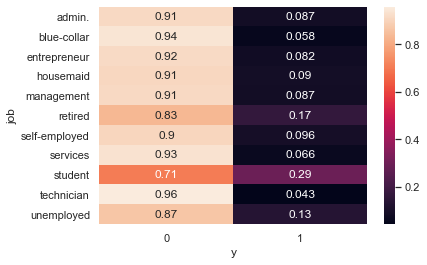

--- marital ---


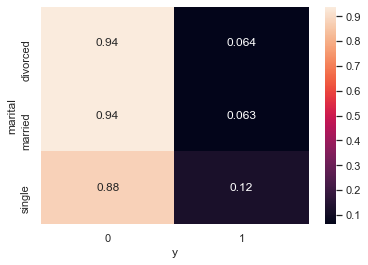

--- education ---


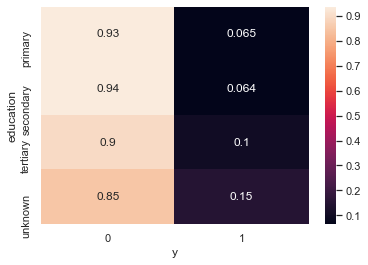

--- default ---


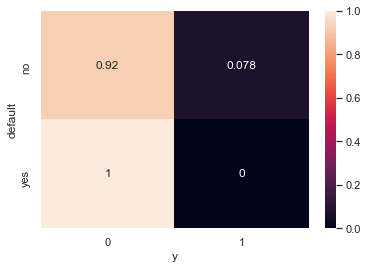

--- housing ---


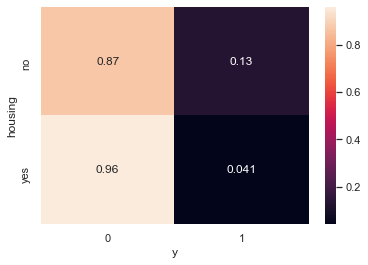

--- loan ---


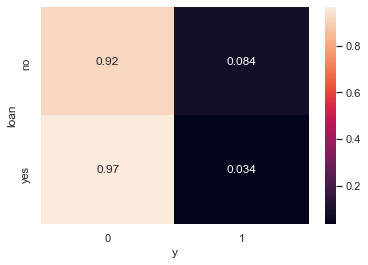

--- contact ---


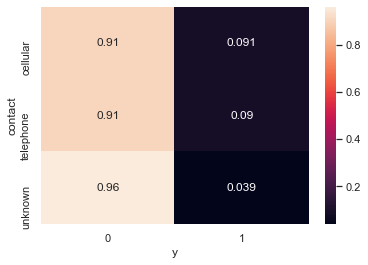

--- month ---


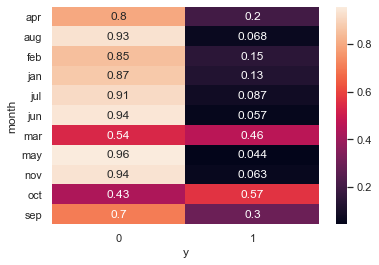

--- poutcome ---


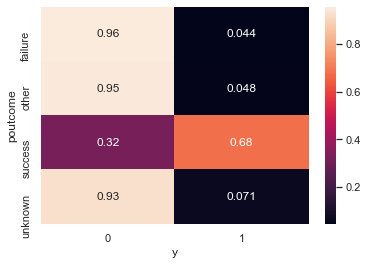

In [14]:
for col in cols_o:
    print('---', col, '---')
    train_cross = pd.crosstab(train[col], train['y'], normalize='index')
    sns.heatmap(train_cross, annot=True)
    plt.show()


In [15]:
# for col1 in cols_o:
#     for col2 in cols_o:
#         if col1 != col2:
#             print('---', col1, '/', col2, '---')
#             fig, ax = plt.subplots(figsize=(12, 4))
#             train_cross = pd.crosstab(train[col1], train[col2], normalize=True)
#             sns.heatmap(train_cross, annot=True)
#             plt.show()


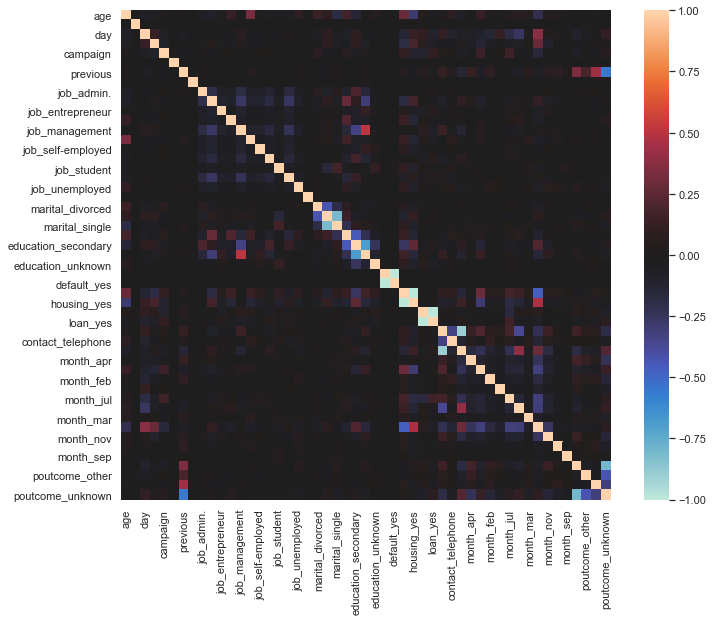

In [16]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(all_df2.corr(), square=True, vmax=1, vmin=-1, center=0)

In [17]:
train['poutcome'].value_counts()

unknown    23099
failure     2717
other        826
success      458
Name: poutcome, dtype: int64

In [18]:
all_df2.corr()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,0.000678,-0.064515,-0.057669,0.033344,0.004698,0.037856,-0.001909,-0.066588,-0.084721,...,0.066956,0.056673,-0.203855,0.041104,0.041941,0.008689,0.003773,-0.011745,0.022476,-0.005676
balance,0.000678,1.000000,0.001772,0.000807,-0.004737,-0.001370,0.005881,0.008135,-0.002549,-0.004242,...,0.000557,-0.000330,0.004964,-0.001568,-0.003625,-0.017171,0.006658,0.008616,0.001956,-0.010520
day,-0.064515,0.001772,1.000000,0.132603,-0.060987,-0.002337,-0.053511,-0.000940,-0.022660,-0.004838,...,-0.256215,0.011048,0.376370,0.039746,0.020906,0.013311,-0.096390,-0.053580,0.007591,0.104774
duration,-0.057669,0.000807,0.132603,1.000000,-0.088835,0.001334,-0.022931,0.000015,-0.026591,0.040158,...,-0.061511,0.018388,0.282184,-0.094004,-0.002793,-0.005180,-0.037555,-0.021270,0.011533,0.037895
campaign,0.033344,-0.004737,-0.060987,-0.088835,1.000000,-0.002440,-0.041406,0.002960,0.023813,-0.024247,...,-0.035968,-0.035457,-0.149529,-0.006144,-0.019698,0.001770,-0.063865,0.020147,-0.029038,0.054848
pdays,0.004698,-0.001370,-0.002337,0.001334,-0.002440,1.000000,0.004625,-0.007176,0.003338,-0.000331,...,0.005162,-0.001688,-0.002011,0.010767,0.003302,-0.004433,0.007724,-0.006520,0.001974,-0.004096
previous,0.037856,0.005881,-0.053511,-0.022931,-0.041406,0.004625,1.000000,-0.006745,0.037528,-0.025703,...,-0.063435,0.065401,-0.059601,0.066582,0.093059,0.020576,0.350973,0.189664,0.437206,-0.547873
y,-0.001909,0.008135,-0.000940,0.000015,0.002960,-0.007176,-0.006745,1.000000,-0.002458,-0.007735,...,-0.004649,0.008498,-0.005809,0.003665,-0.002376,-0.000856,0.002674,0.001285,0.000741,-0.003155
job_admin.,-0.066588,-0.002549,-0.022660,-0.026591,0.023813,0.003338,0.037528,-0.002458,1.000000,-0.195868,...,-0.005466,-0.005655,-0.014223,0.038498,0.000285,-0.000945,0.019292,0.009697,0.026728,-0.030743
job_blue-collar,-0.084721,-0.004242,-0.004838,0.040158,-0.024247,-0.000331,-0.025703,-0.007735,-0.195868,1.000000,...,0.027740,-0.022761,0.103287,-0.060686,-0.017675,-0.002057,-0.034375,0.008298,-0.015753,0.030800


In [19]:
analyze_df = all_df[all_df['y'] != -999]


In [20]:


# for col in analyze_df.columns.drop('y'):
#     plt.figure(figsize=(20, 4))
#     sns.scatterplot(x=analyze_df.index, y=col, hue="y", data=analyze_df)


In [21]:
analyze_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,1,0
1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,3,1
2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,0,0
3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,0,0
4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,1,1,1,0,26661,1,0,0,27,7,345,4,425,0,3,0
27096,35,7,1,1,0,42150,1,0,0,27,7,121,1,719,0,3,0
27097,35,7,1,3,0,34531,0,0,0,28,5,177,2,121,0,3,0


In [22]:
analyze_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        27100 non-null  int64
 1   job        27100 non-null  int32
 2   marital    27100 non-null  int32
 3   education  27100 non-null  int32
 4   default    27100 non-null  int32
 5   balance    27100 non-null  int64
 6   housing    27100 non-null  int32
 7   loan       27100 non-null  int32
 8   contact    27100 non-null  int32
 9   day        27100 non-null  int64
 10  month      27100 non-null  int32
 11  duration   27100 non-null  int64
 12  campaign   27100 non-null  int64
 13  pdays      27100 non-null  int64
 14  previous   27100 non-null  int64
 15  poutcome   27100 non-null  int32
 16  y          27100 non-null  int64
dtypes: int32(9), int64(8)
memory usage: 2.8 MB


In [23]:
# sns.pairplot(analyze_df, hue='y', corner=True, diag_kind="reg")

In [24]:
analyze_df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [25]:
analyze_df['default'].value_counts()

0    27090
1       10
Name: default, dtype: int64

In [26]:
# for col1 in analyze_df.columns.drop(['default', 'loan', 'previous', 'poutcome', 'y']):
#     for col2 in analyze_df.columns.drop(['default', 'loan', 'previous', 'poutcome', 'y']):
#         if col1 != col2:
#             print(col1, col2)
#             sns.scatterplot(x=col1, y=col2, hue="y", data=analyze_df);
#             plt.show()


## One Hot Encoding

In [27]:
ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
ce_ohe.fit(all_df.drop('y', axis=1))


OneHotEncoder(cols=[], drop_invariant=False, handle_missing='value',
              handle_unknown='impute', return_df=True, use_cat_names=False,
              verbose=0)

In [28]:
X = ce_ohe.transform(all_df[all_df['y'] != -999].drop('y', axis=1))
y = all_df[all_df['y'] != -999]['y']

In [29]:
X.shape, y.shape

((27100, 16), (27100,))

In [30]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,1
1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,3
2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,0
3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,0
4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,1,1,1,0,26661,1,0,0,27,7,345,4,425,0,3
27096,35,7,1,1,0,42150,1,0,0,27,7,121,1,719,0,3
27097,35,7,1,3,0,34531,0,0,0,28,5,177,2,121,0,3


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

## XGBoost

In [32]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'max_depth': 3,
#     'eta': 0.1,
    'eval_metric': 'auc',
    'random_state': 0,
#     'early_stopping_rounds': 10,
}

# モデルを学習する
xgb_model = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=500,  # 学習ラウンド数は適当
    verbose_eval=100,
)

[0]	train-auc:0.72459	eval-auc:0.71347
[100]	train-auc:0.90161	eval-auc:0.84953
[200]	train-auc:0.93119	eval-auc:0.84520
[300]	train-auc:0.94862	eval-auc:0.84052
[400]	train-auc:0.96029	eval-auc:0.83554
[499]	train-auc:0.96983	eval-auc:0.82995


In [33]:
all_pred = pd.DataFrame()

In [34]:
xgb_y_pred = xgb_model.predict(xgb.DMatrix(X, label=y))
print(xgb_y_pred)

all_pred['xgb'] = xgb_y_pred


[0.00669284 0.54015756 0.00129763 ... 0.20618121 0.01709955 0.00321649]


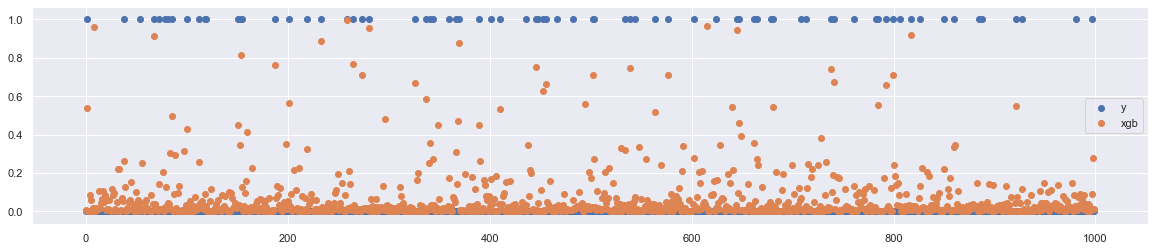

In [35]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='xgb')
plt.legend()

In [36]:
print('auc:', roc_auc_score(y, xgb_model.predict(xgb.DMatrix(X))))


auc: 0.931624253505319


### for sklearn

In [37]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic', max_depth=3, n_estimators=500, eval_metric='auc', random_state=0)
# xgb_model = XGBClassifier(objective='binary:logistic', max_depth=5, learning_rate=0.1, n_estimators=500, eval_metric='auc', random_state=0, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
xgb_y_pred = xgb_model.predict_proba(X)[:,1]
print(xgb_y_pred)

all_pred['xgb_sk'] = xgb_y_pred


[0.00669284 0.54015756 0.00129763 ... 0.20618121 0.01709955 0.00321649]


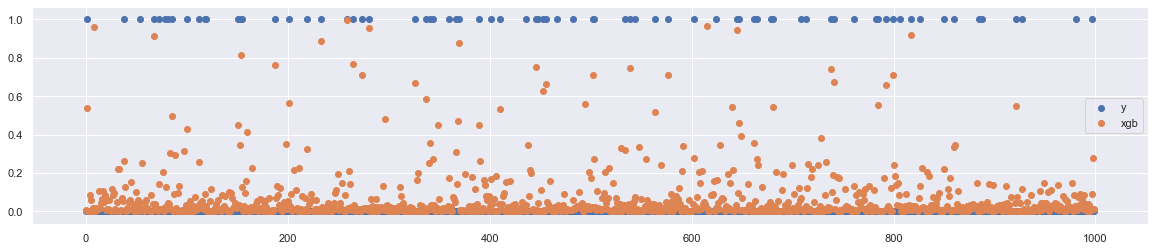

In [39]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='xgb')
plt.legend()

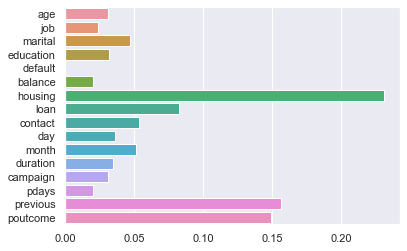

In [40]:
importances = xgb_model.feature_importances_
sns.barplot(importances, X.columns)

### Recursive Feature Elimination

In [41]:
X.shape

(27100, 16)

In [42]:
# for i in list(range(16, 5, -1)):
#     rfe_xgb = RFE(estimator=xgb, n_features_to_select=i, verbose=1)
#     rfe_xgb.fit(X, y)
    
#     xgb_y_pred = rfe_xgb.predict_proba(X)[:,1]

#     plt.figure(figsize=(20, 4))
#     plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
#     plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='xgb')
#     plt.legend()
#     plt.show()


## LightGBM

In [43]:
# 使用モデルはLGB（パラメータチューニング無）
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

lgb_params = {
    'objective': 'binary', 
    'max_depth': 3,
#     'eta': 0.1,
    'metric': 'auc',
    'random_state': 0,
}

lgb_model = lgb.train(
    lgb_params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=100,
    num_boost_round=500
)


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's auc: 0.875722	valid_1's auc: 0.849082
[200]	training's auc: 0.89565	valid_1's auc: 0.852441
[300]	training's auc: 0.910652	valid_1's auc: 0.852049
[400]	training's auc: 0.921516	valid_1's auc: 0.85092
[500]	training's auc: 0.930179	valid_1's auc: 0.849656


In [44]:
lgb_model.params

{'objective': 'binary', 'max_depth': 3, 'metric': 'auc', 'random_state': 0}

In [45]:
lgb_y_pred = lgb_model.predict(X, num_iteration=lgb_model.best_iteration)
print(lgb_y_pred)

all_pred['lgb'] = lgb_y_pred


[0.00663453 0.37120452 0.00243666 ... 0.13943078 0.07942148 0.00345611]


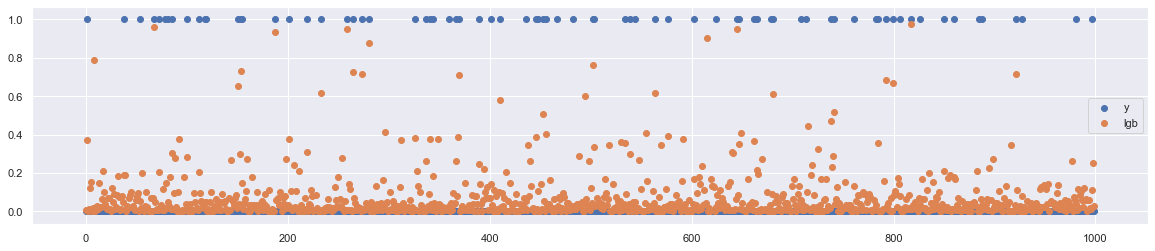

In [46]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], lgb_y_pred[:1000], alpha=1, label='lgb')
plt.legend()

In [47]:
print('auc:', roc_auc_score(y, lgb_model.predict(X)))


auc: 0.907823378327658


### for sklearn

In [48]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(objective='binary', max_depth=3, eval_metric='auc', random_state=0, n_estimators=500)
# lgb = LGBMClassifier(objective='binary', max_depth=3, learning_rate=0.1,eval_metric='auc', n_estimators=1000)
lgb_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=3, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=0, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [49]:
lgb_y_pred = lgb_model.predict_proba(X)[:,1]
print(lgb_y_pred)

all_pred['lgb_sk'] = lgb_y_pred


[0.00477953 0.37436255 0.00149432 ... 0.11880579 0.05352149 0.00252389]


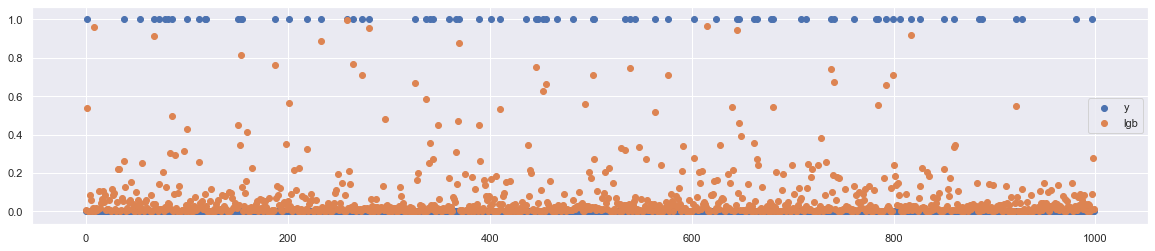

In [50]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='lgb')
plt.legend()

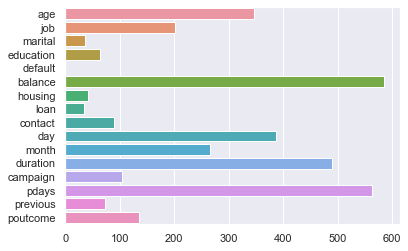

In [52]:
importances = lgb_model.feature_importances_
sns.barplot(importances, X.columns)

### Recursive Feature Elimination

In [53]:
# for i in list(range(16, 5, -1)):
#     rfe_lgb = RFE(estimator=lgb, n_features_to_select=i, verbose=1)
#     rfe_lgb.fit(X, y)
    
#     lgb_y_pred = rfe_lgb.predict_proba(X)[:,1]

#     plt.figure(figsize=(20, 4))
#     plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
#     plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='lgb')
#     plt.legend()
#     plt.show()


In [54]:
all_pred['xgb_diff'] = all_pred['xgb'] - all_pred['xgb_sk']
all_pred['lgb_diff'] = all_pred['lgb'] - all_pred['lgb_sk']

In [55]:
all_pred[(all_pred['xgb_diff'] == 0.0) | (all_pred['lgb_diff'] == 0.0)]

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff
0,0.006693,0.006693,0.006635,0.004780,0.0,0.001855
1,0.540158,0.540158,0.371205,0.374363,0.0,-0.003158
2,0.001298,0.001298,0.002437,0.001494,0.0,0.000942
3,0.004117,0.004117,0.015252,0.018578,0.0,-0.003325
4,0.085413,0.085413,0.119901,0.241594,0.0,-0.121694
...,...,...,...,...,...,...
27095,0.000765,0.000765,0.004709,0.002370,0.0,0.002338
27096,0.040556,0.040556,0.021431,0.030529,0.0,-0.009097
27097,0.206181,0.206181,0.139431,0.118806,0.0,0.020625
27098,0.017100,0.017100,0.079421,0.053521,0.0,0.025900


In [56]:
all_pred['xgb_y'] = all_pred['xgb'].apply(lambda x: 1 if x >= 0.5 else 0)
all_pred['lgb_y'] = all_pred['lgb'].apply(lambda x: 1 if x >= 0.5 else 0)

In [57]:
all_pred['y'] = train['y']

In [58]:
all_pred['xgb_y'].value_counts()

0    26070
1     1030
Name: xgb_y, dtype: int64

In [59]:
all_pred['lgb_y'].value_counts()

0    26314
1      786
Name: lgb_y, dtype: int64

In [60]:
all_pred['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [61]:
all_pred[all_pred['xgb_y'] != all_pred['y']]

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff,xgb_y,lgb_y,y
8,0.958209,0.958209,0.786246,0.925499,0.0,-0.139254,1,1,0
38,0.262764,0.262764,0.190883,0.095198,0.0,0.095685,0,0,1
54,0.042793,0.042793,0.053303,0.069119,0.0,-0.015815,0,0,1
72,0.142244,0.142244,0.206645,0.201789,0.0,0.004856,0,0,1
78,0.022854,0.022854,0.017110,0.017108,0.0,0.000002,0,0,1
...,...,...,...,...,...,...,...,...,...
27021,0.373752,0.373752,0.167656,0.241330,0.0,-0.073674,0,0,1
27055,0.038998,0.038998,0.080861,0.073164,0.0,0.007697,0,0,1
27059,0.257557,0.257557,0.132185,0.138459,0.0,-0.006274,0,0,1
27062,0.478018,0.478018,0.217263,0.260220,0.0,-0.042957,0,0,1


In [62]:
all_pred[all_pred['lgb_y'] != all_pred['y']]

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff,xgb_y,lgb_y,y
1,0.540158,0.540158,0.371205,0.374363,0.0,-0.003158,1,0,1
8,0.958209,0.958209,0.786246,0.925499,0.0,-0.139254,1,1,0
38,0.262764,0.262764,0.190883,0.095198,0.0,0.095685,0,0,1
54,0.042793,0.042793,0.053303,0.069119,0.0,-0.015815,0,0,1
72,0.142244,0.142244,0.206645,0.201789,0.0,0.004856,0,0,1
...,...,...,...,...,...,...,...,...,...
26997,0.104356,0.104356,0.166657,0.171274,0.0,-0.004617,0,0,1
27021,0.373752,0.373752,0.167656,0.241330,0.0,-0.073674,0,0,1
27055,0.038998,0.038998,0.080861,0.073164,0.0,0.007697,0,0,1
27059,0.257557,0.257557,0.132185,0.138459,0.0,-0.006274,0,0,1


In [63]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'max_depth': 3,
#     'eta': 0.1,
    'eval_metric': 'auc',
    'random_state': 0,
#     'early_stopping_rounds': 10,
}

# モデルを学習する
xgb_model1 = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=500,  # 学習ラウンド数は適当
    verbose_eval=100,
)

[0]	train-auc:0.72459	eval-auc:0.71347
[100]	train-auc:0.90161	eval-auc:0.84953
[200]	train-auc:0.93119	eval-auc:0.84520
[300]	train-auc:0.94862	eval-auc:0.84052
[400]	train-auc:0.96029	eval-auc:0.83554
[499]	train-auc:0.96983	eval-auc:0.82995


In [64]:
all_pred['xgb_model1'] = xgb_model1.predict(xgb.DMatrix(X))

In [65]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'max_depth': 3,
#     'eta': 0.1,
    'eval_metric': 'auc',
    'random_state': 0,
#     'early_stopping_rounds': 10,
}

# モデルを学習する
xgb_model2 = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=100,  # 学習ラウンド数は適当
    verbose_eval=100,
)

[0]	train-auc:0.72459	eval-auc:0.71347
[99]	train-auc:0.90129	eval-auc:0.84917


In [69]:
all_pred['xgb_model2'] = xgb_model2.predict(xgb.DMatrix(X))

In [67]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'max_depth': 3,
#     'eta': 0.1,
    'eval_metric': 'auc',
    'random_state': 0,
#     'early_stopping_rounds': 10,
}

# モデルを学習する
xgb_model3 = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=1000,  # 学習ラウンド数は適当
    verbose_eval=100,
)

[0]	train-auc:0.72459	eval-auc:0.71347
[100]	train-auc:0.90161	eval-auc:0.84953
[200]	train-auc:0.93119	eval-auc:0.84520
[300]	train-auc:0.94862	eval-auc:0.84052
[400]	train-auc:0.96029	eval-auc:0.83554
[500]	train-auc:0.96987	eval-auc:0.82996
[600]	train-auc:0.97730	eval-auc:0.82814
[700]	train-auc:0.98242	eval-auc:0.82412
[800]	train-auc:0.98684	eval-auc:0.82118
[900]	train-auc:0.98959	eval-auc:0.82027
[999]	train-auc:0.99203	eval-auc:0.81760


In [70]:
all_pred['xgb_model3'] = xgb_model3.predict(xgb.DMatrix(X))

In [71]:
all_pred

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff,xgb_y,lgb_y,y,xgb_model1,xgb_model2,xgb_model3
0,0.006693,0.006693,0.006635,0.004780,0.0,0.001855,0,0,0,0.006693,0.005150,0.003249
1,0.540158,0.540158,0.371205,0.374363,0.0,-0.003158,1,0,1,0.540158,0.184901,0.695013
2,0.001298,0.001298,0.002437,0.001494,0.0,0.000942,0,0,0,0.001298,0.001854,0.000646
3,0.004117,0.004117,0.015252,0.018578,0.0,-0.003325,0,0,0,0.004117,0.016793,0.000901
4,0.085413,0.085413,0.119901,0.241594,0.0,-0.121694,0,0,0,0.085413,0.231316,0.013980
...,...,...,...,...,...,...,...,...,...,...,...,...
27095,0.000765,0.000765,0.004709,0.002370,0.0,0.002338,0,0,0,0.000765,0.004108,0.000319
27096,0.040556,0.040556,0.021431,0.030529,0.0,-0.009097,0,0,0,0.040556,0.049240,0.021386
27097,0.206181,0.206181,0.139431,0.118806,0.0,0.020625,0,0,0,0.206181,0.112105,0.223377
27098,0.017100,0.017100,0.079421,0.053521,0.0,0.025900,0,0,0,0.017100,0.047055,0.005767


In [74]:
all_pred[all_pred['y'] == 1]

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff,xgb_y,lgb_y,y,xgb_model1,xgb_model2,xgb_model3
1,0.540158,0.540158,0.371205,0.374363,0.0,-0.003158,1,0,1,0.540158,0.184901,0.695013
38,0.262764,0.262764,0.190883,0.095198,0.0,0.095685,0,0,1,0.262764,0.060833,0.515917
54,0.042793,0.042793,0.053303,0.069119,0.0,-0.015815,0,0,1,0.042793,0.144420,0.025287
67,0.913317,0.913317,0.962477,0.917046,0.0,0.045432,1,1,1,0.913317,0.975871,0.934906
72,0.142244,0.142244,0.206645,0.201789,0.0,0.004856,0,0,1,0.142244,0.141496,0.235864
...,...,...,...,...,...,...,...,...,...,...,...,...
27023,0.919948,0.919948,0.866981,0.894060,0.0,-0.027078,1,1,1,0.919948,0.871578,0.936181
27055,0.038998,0.038998,0.080861,0.073164,0.0,0.007697,0,0,1,0.038998,0.152693,0.036673
27059,0.257557,0.257557,0.132185,0.138459,0.0,-0.006274,0,0,1,0.257557,0.072215,0.643001
27060,0.959513,0.959513,0.953661,0.932874,0.0,0.020788,1,1,1,0.959513,0.944450,0.896691


In [75]:
all_pred[all_pred['y'] == 0]

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff,xgb_y,lgb_y,y,xgb_model1,xgb_model2,xgb_model3
0,0.006693,0.006693,0.006635,0.004780,0.0,0.001855,0,0,0,0.006693,0.005150,0.003249
2,0.001298,0.001298,0.002437,0.001494,0.0,0.000942,0,0,0,0.001298,0.001854,0.000646
3,0.004117,0.004117,0.015252,0.018578,0.0,-0.003325,0,0,0,0.004117,0.016793,0.000901
4,0.085413,0.085413,0.119901,0.241594,0.0,-0.121694,0,0,0,0.085413,0.231316,0.013980
5,0.057834,0.057834,0.151439,0.115880,0.0,0.035560,0,0,0,0.057834,0.106503,0.040038
...,...,...,...,...,...,...,...,...,...,...,...,...
27095,0.000765,0.000765,0.004709,0.002370,0.0,0.002338,0,0,0,0.000765,0.004108,0.000319
27096,0.040556,0.040556,0.021431,0.030529,0.0,-0.009097,0,0,0,0.040556,0.049240,0.021386
27097,0.206181,0.206181,0.139431,0.118806,0.0,0.020625,0,0,0,0.206181,0.112105,0.223377
27098,0.017100,0.017100,0.079421,0.053521,0.0,0.025900,0,0,0,0.017100,0.047055,0.005767


In [86]:
all_pred.iloc[:,8:]

,y,xgb_model1,xgb_model2,xgb_model3
0,0,0.006693,0.005150,0.003249
1,1,0.540158,0.184901,0.695013
2,0,0.001298,0.001854,0.000646
3,0,0.004117,0.016793,0.000901
4,0,0.085413,0.231316,0.013980
...,...,...,...,...
27095,0,0.000765,0.004108,0.000319
27096,0,0.040556,0.049240,0.021386
27097,0,0.206181,0.112105,0.223377
27098,0,0.017100,0.047055,0.005767


In [92]:
all_pred['xgb_max'] = all_pred.iloc[:,9:].max(axis=1)

In [93]:
all_pred

,xgb,xgb_sk,lgb,lgb_sk,xgb_diff,lgb_diff,xgb_y,lgb_y,y,xgb_model1,xgb_model2,xgb_model3,xgb_max
0,0.006693,0.006693,0.006635,0.004780,0.0,0.001855,0,0,0,0.006693,0.005150,0.003249,0.006693
1,0.540158,0.540158,0.371205,0.374363,0.0,-0.003158,1,0,1,0.540158,0.184901,0.695013,0.695013
2,0.001298,0.001298,0.002437,0.001494,0.0,0.000942,0,0,0,0.001298,0.001854,0.000646,0.001854
3,0.004117,0.004117,0.015252,0.018578,0.0,-0.003325,0,0,0,0.004117,0.016793,0.000901,0.016793
4,0.085413,0.085413,0.119901,0.241594,0.0,-0.121694,0,0,0,0.085413,0.231316,0.013980,0.231316
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,0.000765,0.000765,0.004709,0.002370,0.0,0.002338,0,0,0,0.000765,0.004108,0.000319,0.004108
27096,0.040556,0.040556,0.021431,0.030529,0.0,-0.009097,0,0,0,0.040556,0.049240,0.021386,0.049240
27097,0.206181,0.206181,0.139431,0.118806,0.0,0.020625,0,0,0,0.206181,0.112105,0.223377,0.223377
27098,0.017100,0.017100,0.079421,0.053521,0.0,0.025900,0,0,0,0.017100,0.047055,0.005767,0.047055


In [109]:
aa = all_pred[(all_pred['xgb_max'] >= 0.5)]['y']
print(aa.sum())
print(aa.shape)
# 合計値が多い方がよい
print(1204/1459)

1204
(1459,)
0.8252227553118574


In [110]:
bb = all_pred[(all_pred['xgb_max'] < 0.5)]['y']
print(bb.sum())
print(bb.shape)
# 合計値が少ない方がよい
print(908/25641)

908
(25641,)
0.035412035412035414


In [111]:
aa = all_pred[(all_pred['xgb'] >= 0.5)]['y']
print(aa.sum())
print(aa.shape)
# 合計値が多い方がよい
print(873/1030)

873
(1030,)
0.8475728155339806


In [112]:
bb = all_pred[(all_pred['xgb'] < 0.5)]['y']
print(bb.sum())
print(bb.shape)
# 合計値が少ない方がよい
print(1239/26070)

1239
(26070,)
0.0475258918296893


In [ ]:
# sample[1] = pred
# sample.to_csv('submit_20200809_03.csv', index=None, header=None)